In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from prophet import Prophet

In [9]:
!pip uninstall torch -y
!pip install torch==2.0.1

Found existing installation: torch 1.13.0
Uninstalling torch-1.13.0:
  Successfully uninstalled torch-1.13.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 MB 1.3 MB/s eta 0:00:0000:0100:020m

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
movies = pd.read_csv('/Users/antropravin/Desktop/Bezohminds/Task/Movie Recommendation System/Cleaned Movie Data.csv')
user_profiles = pd.read_csv('/Users/antropravin/Desktop/Bezohminds/Task/Movie Recommendation System/User_Profiles.csv')

In [3]:
user_movie_matrix = []
for index, user in user_profiles.iterrows():
    for movie in user['watched_movies'][1:-1].split(','):
        user_movie_matrix.append([user['user_id'], int(movie), 1 if int(movie) in eval(user['liked_movies']) else 0])
interaction_df = pd.DataFrame(user_movie_matrix, columns=["user_id", "movie_id", "rating"])
print(interaction_df.head())

   user_id  movie_id  rating
0        1       707       0
1        1      1563       1
2        1      9085       0
3        1    970308       0
4        1    606236       0


In [11]:
class ALSModel(nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super(ALSModel, self).__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)
        
    def forward(self, user, item):
        return (self.user_factors(user) * self.item_factors(item)).sum(1)

# Define number of users, movies, and factors
n_users = interaction_df['user_id'].nunique()
n_movies = interaction_df['movie_id'].nunique()
n_factors = 50

# Instantiate model
model = ALSModel(n_users, n_movies, n_factors)

# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Convert data to tensors
user_tensor = torch.LongTensor(interaction_df['user_id'].values)
movie_tensor = torch.LongTensor(interaction_df['movie_id'].values)
rating_tensor = torch.FloatTensor(interaction_df['rating'].values)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(user_tensor, movie_tensor)
    loss = loss_fn(predictions, rating_tensor)
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

IndexError: index out of range in self

In [12]:
def recommend_movies(user_id, model, movies_df, top_n=10):
    user_tensor = torch.LongTensor([user_id] * n_movies)
    movie_tensor = torch.LongTensor(range(n_movies))
    
    with torch.no_grad():
        scores = model(user_tensor, movie_tensor)
        
    # Get top N recommendations
    top_movies = scores.argsort(descending=True)[:top_n]
    recommended_movies = movies_df.iloc[top_movies.numpy()]
    
    return recommended_movies[['title', 'genres', 'vote_average']]

# Test recommendations for user 5
print(recommend_movies(5, model, movies))

                               title  \
1165          The 40 Year Old Virgin   
6248               Love and Monsters   
4886      The Hawks and the Sparrows   
3277                           Armor   
3065                  Wreck-It Ralph   
1161                      Robin Hood   
3078                      Wanderlust   
8245                         Corsage   
5214  The Curse of the Jade Scorpion   
3385                      Easy Rider   

                                                 genres  vote_average  
1165                                    Comedy, Romance         6.400  
6248  Comedy, Action, Adventure, Fantasy, Science Fi...         7.297  
4886                                    Comedy, Fantasy         7.300  
3277                     Action, Crime, Thriller, Drama         5.600  
3065               Family, Animation, Comedy, Adventure         7.300  
1161                       Animation, Family, Adventure         7.300  
3078                                    Comedy, Romance

Sales Forecasting (ARIMA)

In [13]:
# Aggregate popularity over time (monthly)
movies['release_date'] = pd.to_datetime(movies['release_date'])
movies['month'] = movies['release_date'].dt.to_period('M')
monthly_popularity = movies.groupby('month')['popularity'].sum().reset_index()
monthly_popularity['month'] = monthly_popularity['month'].astype(str)

print(monthly_popularity.head())

     month  popularity
0  1898-01       3.824
1  1902-06       3.818
2  1903-01       3.568
3  1911-03       7.136
4  1915-02       7.136


In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Define ARIMA model
arima_model = ARIMA(monthly_popularity['popularity'], order=(5, 1, 2))
arima_result = arima_model.fit()

# Forecast next 12 months
forecast = arima_result.forecast(steps=12)
print(forecast)

960    -311.893176
961    -210.852632
962    -481.053598
963    2197.496158
964     456.693344
965      59.232689
966      74.212578
967    -311.200910
968    1148.698051
969     552.034103
970     270.165765
971     265.250084
Name: predicted_mean, dtype: float64


/Users/antropravin/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 1.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 kB 1.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


10:43:44 - cmdstanpy - INFO - Chain [1] start processing
10:43:44 - cmdstanpy - INFO - Chain [1] done processing


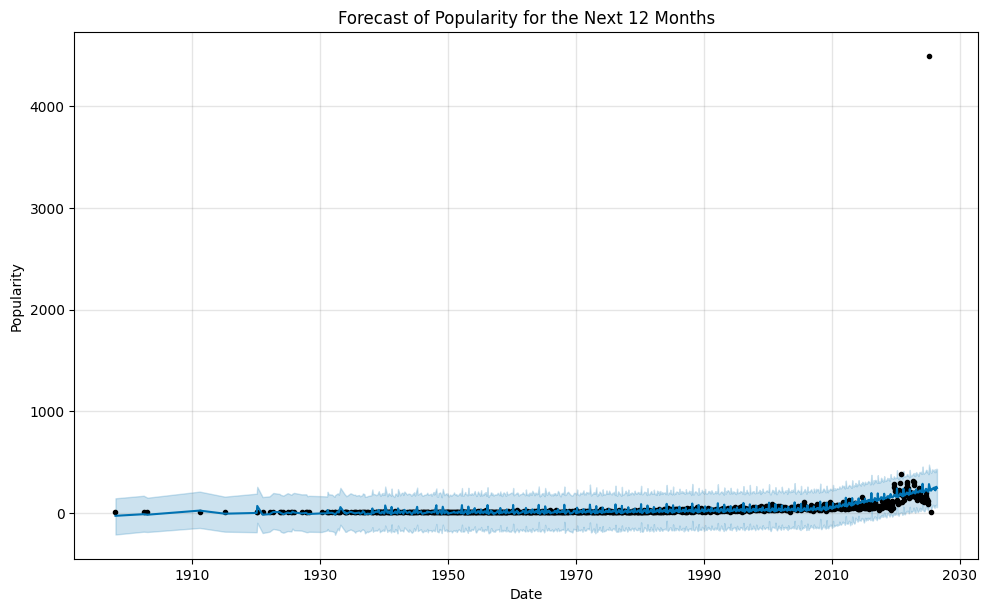

In [22]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Rename columns to Prophet's format
prophet_data = monthly_popularity.rename(columns={'month': 'ds', 'popularity': 'y'})

# Define and fit Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Forecast next 12 months
future = prophet_model.make_future_dataframe(periods=12, freq='M')
forecast = prophet_model.predict(future)

# Plot the forecast
fig = prophet_model.plot(forecast)

# Add labels and title using Matplotlib
plt.xlabel('Date')  # x-axis label
plt.ylabel('Popularity')  # y-axis label
plt.title('Forecast of Popularity for the Next 12 Months')  # plot title

# Show the plot
plt.show()


In [ ]:
from fastapi import FastAPI
import json

app = FastAPI()

@app.get("/recommend/")
def recommend(user_id: int):
    recommended_movies = recommend_movies(user_id, model, movies)
    return json.loads(recommended_movies.to_json(orient="records"))

@app.get("/forecast/")
def sales_forecast():
    return {"forecast": forecast.tolist()}

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)
